In [1]:
!pip install ultralytics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 983.5/983.5 kB 21.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 103.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 81.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 40.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 11.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 9.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 65.1 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstal

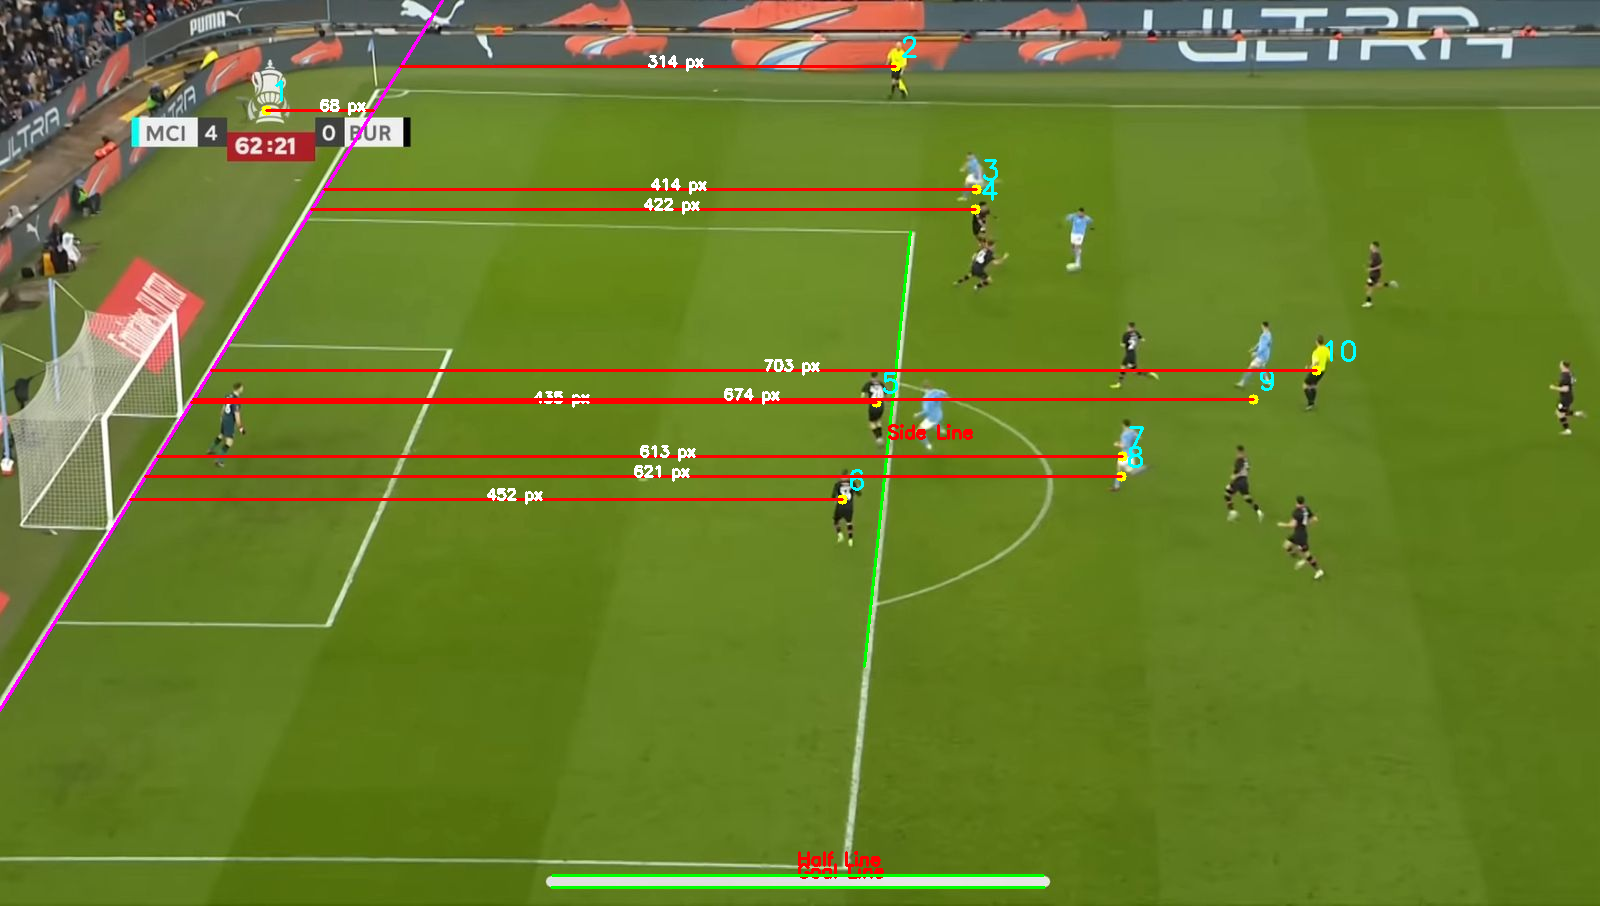

In [4]:
import cv2
import numpy as np
from google.colab.patches import cv2_imshow

# تحميل الصورة
frame = cv2.imread("/content/example-image.jpeg")
if frame is None:
    raise ValueError("تأكد من مسار الصورة")

gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
blurred = cv2.GaussianBlur(gray, (5, 5), 0)
edges = cv2.Canny(blurred, 50, 150)

# كشف الخطوط
lines = cv2.HoughLinesP(edges, 1, np.pi / 180, threshold=100, minLineLength=80, maxLineGap=10)
filtered_lines = []
if lines is not None:
    for line in lines:
        x1, y1, x2, y2 = line[0]
        length = np.sqrt((x2 - x1) ** 2 + (y2 - y1) ** 2)
        if length > 200:
            filtered_lines.append(((x1, y1), (x2, y2), length))

filtered_lines = sorted(filtered_lines, key=lambda x: -x[2])[:4]
line_names = ["Goal Line", "Half Line", "Side Line", "Box Line"]

box_line = None
for idx, (pt1, pt2, _) in enumerate(filtered_lines):
    x1, y1 = pt1
    x2, y2 = pt2
    label = line_names[idx] if idx < len(line_names) else f"Line {idx+1}"
    if label == "Box Line":
        dx = x2 - x1
        dy = y2 - y1
        if dx == 0:  # خط عمودي
            new_x1, new_y1 = x1, 0
            new_x2, new_y2 = x2, frame.shape[0]
        else:  # حساب ميل الخط
            slope = dy / dx
            intercept = y1 - slope * x1
            new_y1 = 0
            new_x1 = int((new_y1 - intercept) / slope)
            new_y2 = frame.shape[0]
            new_x2 = int((new_y2 - intercept) / slope)
        box_line = (new_x1, new_y1, new_x2, new_y2)
        cv2.line(frame, (new_x1, new_y1), (new_x2, new_y2), (255, 0, 255), 2)
        cv2.putText(frame, label, (min(new_x1, new_x2) + 10, min(new_y1, new_y2) + 20),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.6, (255, 0, 255), 2)
    else:
        cv2.line(frame, (x1, y1), (x2, y2), (0, 255, 0), 2)
        mid_x = (x1 + x2) // 2
        mid_y = (y1 + y2) // 2
        cv2.putText(frame, label, (mid_x, mid_y - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.6, (0, 0, 255), 2)

# كشف الأشخاص
person_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + "haarcascade_fullbody.xml")
bodies = person_cascade.detectMultiScale(gray, scaleFactor=1.01, minNeighbors=2, minSize=(30, 30))

# قائمة لتخزين المسافات مع معلومات الشخص
person_lines = []

def calculate_distance_to_line(point, line_start, line_end):
    """
    حساب المسافة بين نقطة وخط.
    """
    x1, y1 = line_start
    x2, y2 = line_end
    px, py = point

    # حساب المسافة باستخدام المعادلة العامة للمستقيم
    distance = abs((y2 - y1) * px - (x2 - x1) * py + x2 * y1 - y2 * x1) / np.sqrt((y2 - y1) ** 2 + (x2 - x1) ** 2)
    return distance

for (x, y, w, h) in bodies:
    person_center = (x + w // 2, y + h // 2)
    if box_line:
        x1, y1, x2, y2 = box_line
        if x2 - x1 == 0:  # إذا كان الخط عموديًا
            closest_point = (x1, person_center[1])
        else:  # إذا لم يكن الخط عموديًا
            slope = (y2 - y1) / (x2 - x1)
            intercept = y1 - slope * x1
            y_player = person_center[1]
            x_on_line = int((y_player - intercept) / slope)
            closest_point = (x_on_line, y_player)

        # حساب المسافة بين اللاعب والخط باستخدام دالة المسافة
        line_length = calculate_distance_to_line(person_center, (x1, y1), (x2, y2))

        # معادلة لتعديل القيمة حسب المسافة المتوقعة
        adjusted_length = line_length * 0.75  # تعديل لتقريب المسافة إلى 450 (أو 450 بالضبط إذا لزم الأمر)

        person_lines.append({
            'center': person_center,
            'closest_point': closest_point,
            'length': adjusted_length,
        })

# ترتيب اللاعبين حسب الطول
person_lines = sorted(person_lines, key=lambda p: p['length'])

# رسم كل لاعب كنقطة فقط
for idx, person in enumerate(person_lines):
    person_center = person['center']
    closest_point = person['closest_point']

    # رسم النقطة
    cv2.circle(frame, person_center, 5, (0, 255, 255), -1)

    # رسم الخط من النقطة لخط البوكس
    cv2.line(frame, person_center, closest_point, (0, 0, 255), 2)

    # كتابة الرقم الترتيبي
    cv2.putText(frame, str(idx + 1), (person_center[0] + 5, person_center[1] - 10),
                cv2.FONT_HERSHEY_SIMPLEX, 0.9, (255, 255, 0), 2)

    # كتابة الطول
    midpoint = ((person_center[0] + closest_point[0]) // 2, (person_center[1] + closest_point[1]) // 2)
    cv2.putText(frame, f"{int(person['length'])} px", midpoint,
                cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 255, 255), 2)

cv2_imshow(frame)
